# **STAGE PONTS INSTRUMENTES - Notebook 14**


## Table of Contents

### 0. [Bibliothèques](#0/-Bibliothèques)
### I. [Calibration avec décalage](#I/-Calibration-avec-décalage)
### II. [Fonctions d'automatisation de test](#II/-Fonctions-d'automatisation-de-test)
### III. [Résultats calibration avec décalage](#III/-Résultats-calibration-avec-décalage)
### IV. [Séparation de deux pics superposés](#IV/-Séparation-de-deux-pics-superposés)
1. [Isolement des camions concernés](#IV.1-Isolement-des-camions-concernés)
2. [Reconstitution des peaks sur les deux camions anormaux](##IV.2-Reconstitution-des-peaks-sur-les-deux-camions-anormaux)

### V. [Recherche automatique de la position de la superposition (avec la largeur des pics)](#V/-Recherche-automatique-de-la-position-de-la-superpostion-(avec-largeur-des-pics))

### VI. [Décalage sur tous les pics (sans superposition ou surestimation](#VI/-Décalage-sur-tous-les-pics-(sans-superposition-ou-surestimation))

### VII. [Reconstruction sur infl0 (méthode indépendante)](#VII/-Reconstruction-sur-infl0-(méthode-indépendante))
### VIII. [Surestimation du nombre d'essieux](#VIII/-Surestimation-du-nombre-d'essieux)


**Dans ce Notebook, nous allons essayer d'intégrer le choix du meilleur décalage dans la calibration puis nous essayerons de compenser les pics manquants (moinds de pics que d'essieux) pour les signaux concernés. Finalement nous essayerons aussi de surestimer le nombre d'essieux, pour voir comment l'algorithme agit**

## 0/ Bibliothèques

In [1]:
import matplotlib.pyplot as plt
from Bwifsttar import load_senlis_modified

## I/ Calibration avec décalage

**Ici, on intègre dans la calibration le décalage des peaks**

In [2]:
def prepare_least_squares_decalage(truck, length,peaks):
    """
        Données :
            - truck :namedTuple Truck
            - length : longueur de la LI
            - peaks : peaks que nous voulons attribuer au truck
        Sorties : 
            - A : MatriceT dans les anciennes notations (voir calibration multitrucks)
            - b : signal
    """
    
    from Previous_files.bwim import create_toeplitz
    import numpy as np
    
    shape = truck.signals.shape#prend les dimensions du signal du camion (y)
    toeplitz = create_toeplitz(shape[-1], length, peaks) #Da 
    A = np.sum(truck.weights[:,None,None] * toeplitz, axis=0)# A = Somme des wa*Da = T
    b = truck.signals # b = y (le signal)
    if len(shape) == 2:
        A = np.tile(A, reps=(shape[0],1))
        b = np.concatenate(b)
    return A, b # retourne le signal et A (correspondant à T dans le cours)


Peaks :  [317 397 522 549 575]


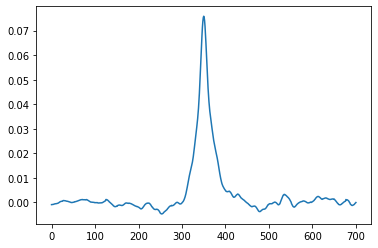

In [6]:
def calibration_decalage(truck, l2_reg=None, tv_reg=None):# pour le moment aucune régularization
    """
        Données :
            - trucks : liste des camions de calibration
            - l2_reg : Régularisation L2
            - tv_reg : Régularisation Totale Variance
        Sorties :
            - influence_finale.x : Ligne d'influence estimée à partir des camions de calibration
        Fonction : Calcul la ligne d'influence à partir d'une liste de camions en cherchant les meilleurs peaks
    """
    from scipy.optimize import minimize
    from Bwifsttar import prepare_least_squares_decalage,find_best_peaks,get_std,prepare_regularization
    import numpy as np

    As, bs = prepare_least_squares_decalage(truck,701,truck.peaks)#retourne T et y
    
    for a in As:
        a = a.astype(float)
    for b in bs:
        b = b.astype(float)
    ws = np.array([])
    ws=np.append(ws,1/get_std(truck))
    ws = ws/(np.sum(ws)) #on centre autour de 1   
    
    As, bs = prepare_regularization(As, bs, l2_reg, tv_reg)#Aucune régularisation pour le moment
      
    infl,_, _, _ = np.linalg.lstsq(As,bs, rcond=None)  

    peaks = find_best_peaks(truck,2,infl)
    print("Peaks : ",peaks)
    As, bs = prepare_least_squares_decalage(truck,701,peaks)#retourne T et y

    
    #def func_finale_to_min(h_alpha):
    def func_finale_to_min(h,As,Bs,ws):
        


        return ws*np.linalg.norm(As@h-bs)**2



    from scipy.optimize import minimize

    influence_alpha = minimize(func_finale_to_min,infl,method='SLSQP',args=(As,bs,ws),tol=0.001)#utiliser CG pour plus rapidité
    #,constraints=cons
    #res = minimize(func_finale_to_min,params_0)#utiliser CG pour plus rapidité
    resultat = influence_alpha.x
    
    

    
    return influence_alpha.x


calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
plt.figure()
plt.plot(calibration_decalage(calibration_trucks[3]))
plt.show()

## II/ Fonctions d'automatisation de test

In [4]:
def get_SE(repartition):
    
    """
        ***** Get Sous Ensemble *****
        Retourne les deux sous ensembles aléatoirement choisis
        Repartition /30 camions
        
    """
    from Bwifsttar import load_senlis_modified
    import numpy as np
    
    
    
    print("********** Working on SEs... **********")
    calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
    calibration_trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
    traffic_trucks = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]
    ensemble_trucks = []
    se_LI = []
    se_Poids = []

    for i in range(0,len(calibration_trucks)):
        ensemble_trucks.append(calibration_trucks[i])
    for j in range(0,len(traffic_trucks)):
        ensemble_trucks.append(traffic_trucks[i])
    
    n = len(ensemble_trucks)
    idx= np.arange(0,len(ensemble_trucks))
    np.random.shuffle(idx)
    #print(idx)
    for k in idx[:repartition]:
        se_LI.append(ensemble_trucks[k])
    for k in idx[repartition:]:
        se_Poids.append(ensemble_trucks[k])
    

    return se_LI,se_Poids

"""se1,se2 = get_SE(20)
print(len(se1))
print(len(se2))"""


'se1,se2 = get_SE(20)\nprint(len(se1))\nprint(len(se2))'

In [5]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
calibration_trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
traffic_trucks = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

In [ ]:

def get_LI(se_LI):
    """
        Prend en paramètre le sous ensemble de camions pour interpoler la LI /vitesses
        Retourne la fonction interpolée
    """
    import numpy as np
    from Bwifsttar import calibration_decalage
    from scipy.interpolate import interp1d

    
    print("********** Working on LI... **********")
    list_speeds = []
    list_infl = []
    for i,truck in enumerate(se_LI):
        list_speeds.append(se_LI[i].speed)
        infl = calibration_decalage(se_LI[i],l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
        list_infl.append(infl)
        
    func1D   = interp1d(list_speeds, list_infl, fill_value="extrapolate",axis=0)#permet à partir de meters et infuence de trouver une approximation de influence = f(meters)
    return func1D
func = get_LI(calibration_trucks)

********** Working on LI... **********
Peaks :  [261 341 470 493 516]
Peaks :  [262 342 467 494 521]
Peaks :  [317 397 522 549 575]


In [7]:

def get_poids(se_Poids,func1D):
    """
        Prend comme paramètre le sous ensemble de poids et la fonction interp LI/Vitesses
        Retourne la liste des poids estimés pour ces camions
    """
    import numpy as np
    from Bwifsttar import find_best_peaks,estimation_peaks
    
    print("********** Working on weights... **********")
    list_poids = []
    for i,truck in enumerate(se_Poids):

        decalage = find_best_peaks(truck,2,func1D(truck.speed))
        w = estimation_peaks(truck,decalage, func1D(truck.speed))
        list_poids.append(w)
    list_poids = np.array(list_poids)
    return list_poids

poids = get_poids(traffic_trucks,func)


********** Working on weights... **********


In [8]:
def get_erreur_essieu(se2,list_poids_estimes):
    import numpy as np
    
    print("********** Working on errors... **********")
    list_erreurs_essieu = []
    list_erreurs_totales = []
    for i,truck in enumerate(se2):
        poids_reel = truck.weights
        poids_total_reel= np.sum(truck.weights)
        poids_estime = list_poids_estimes[i]
        poids_total_estime = np.sum(list_poids_estimes[i])
        diff = abs(poids_reel-poids_estime)
        diff_totale = abs(poids_total_reel-poids_total_estime)
        list_erreurs_essieu.append(diff)
        list_erreurs_totales.append(diff_totale)
    list_erreurs_essieu = np.array(list_erreurs_essieu)
    list_erreurs_totales = np.array(list_erreurs_totales)
    return list_erreurs_essieu,list_erreurs_totales

"""scores,scores_totaux = get_erreur_essieu(traffic_trucks,poids)
print("Scores par essieu (t) \n", scores)
for j,i in enumerate(scores):
    try:
        print("\nScore Essieu (t) "+str(j),scores.T[j])
        print("Score moyen sur l'essieu (t) "+str(j),np.sum(scores.T[j])/len(scores.T[j]))
    except:
        continue
print("\nScores totaux (t) : ",scores_totaux)
print("\nScore total moyen (t) :",np.sum(scores_totaux)/len(scores_totaux))"""

'scores,scores_totaux = get_erreur_essieu(traffic_trucks,poids)\nprint("Scores par essieu (t) \n", scores)\nfor j,i in enumerate(scores):\n    try:\n        print("\nScore Essieu (t) "+str(j),scores.T[j])\n        print("Score moyen sur l\'essieu (t) "+str(j),np.sum(scores.T[j])/len(scores.T[j]))\n    except:\n        continue\nprint("\nScores totaux (t) : ",scores_totaux)\nprint("\nScore total moyen (t) :",np.sum(scores_totaux)/len(scores_totaux))'

## III/ Résultats calibration avec décalage

**Camions de calibration**

Speed :  18.96294211024312
Peaks :  [266 367 527 559 591]


<IPython.core.display.Javascript object>


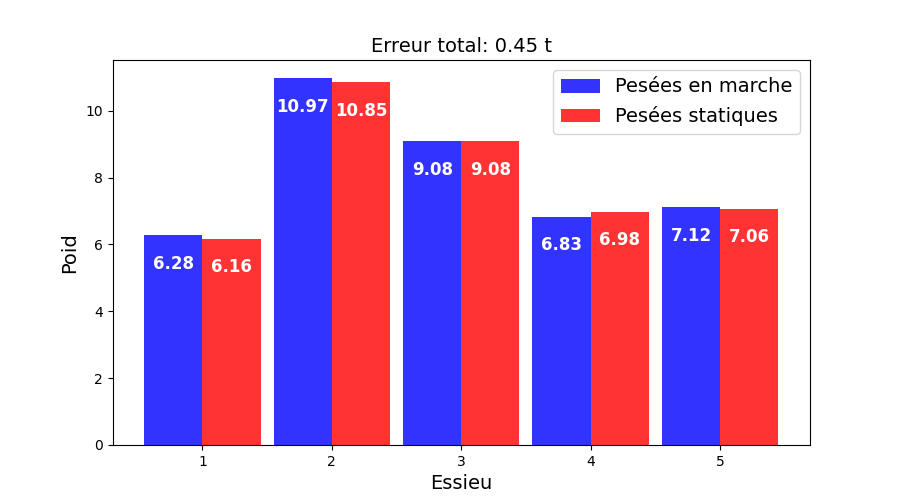

Speed :  24.00002912772182
Peaks :  [263 342 471 494 518]


<IPython.core.display.Javascript object>


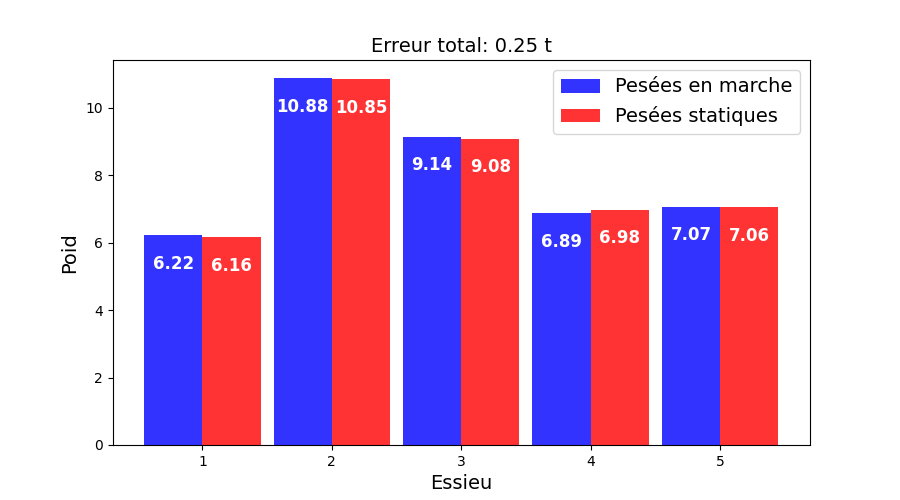

Speed :  18.963018634210332
Peaks :  [266 366 526 558 590]


<IPython.core.display.Javascript object>


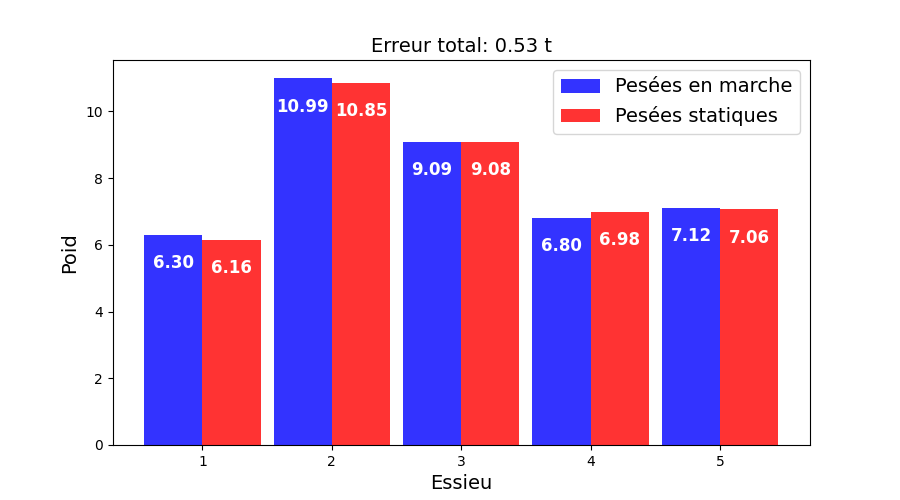

Speed :  21.63376871440886
Peaks :  [263 347 480 508 536]


<IPython.core.display.Javascript object>


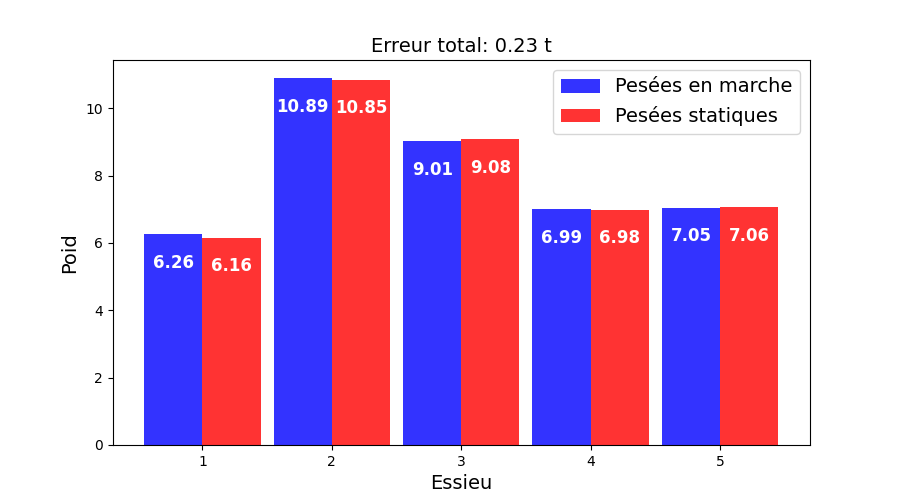

Speed :  24.380991984594182
Peaks :  [261 341 472 492 514]


<IPython.core.display.Javascript object>


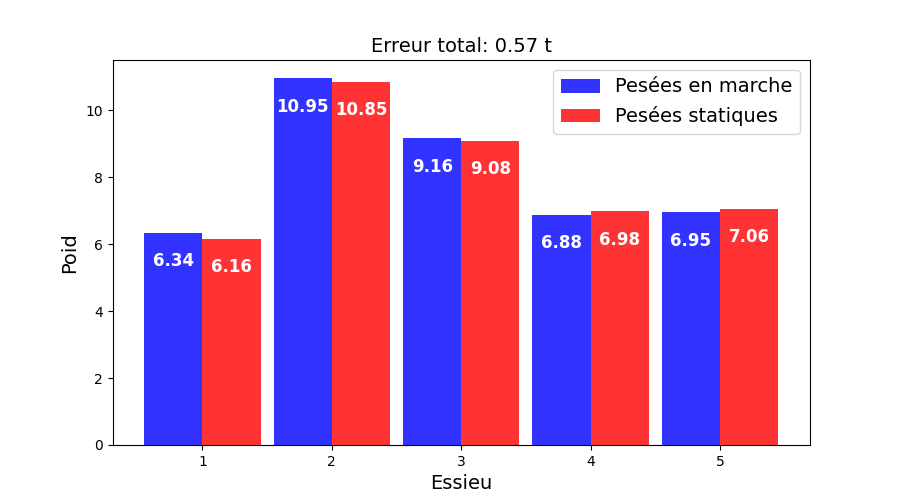

Speed :  18.50599705565925
Peaks :  [266 367 527 560 593]


<IPython.core.display.Javascript object>


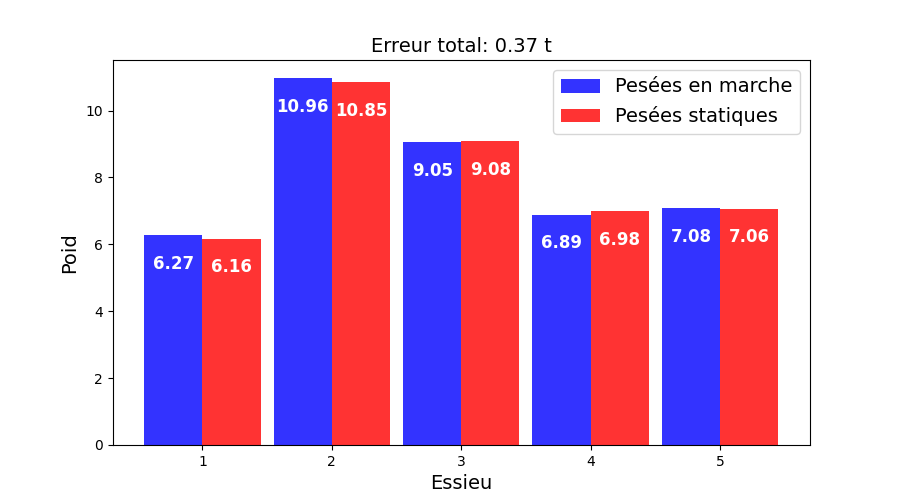

Speed :  23.272699098967962
Peaks :  [262 342 467 494 521]


<IPython.core.display.Javascript object>


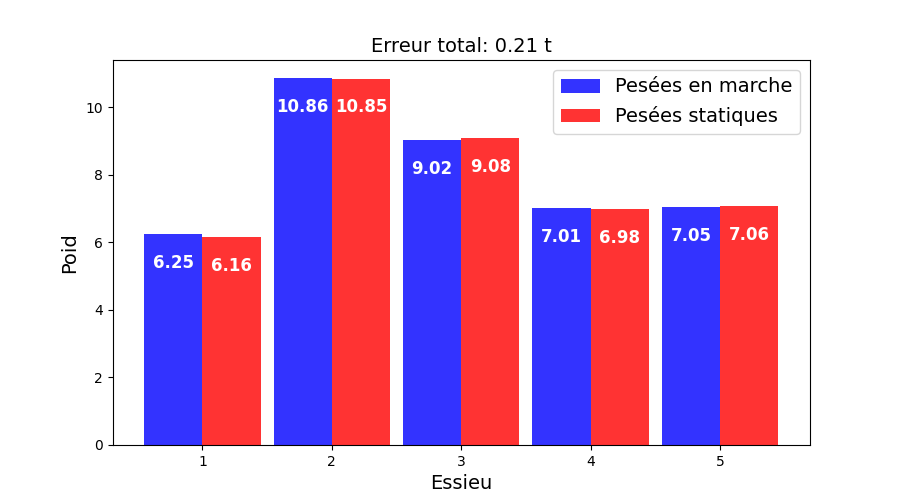

Speed :  18.731689060807692
Peaks :  [266 368 528 561 593]


<IPython.core.display.Javascript object>


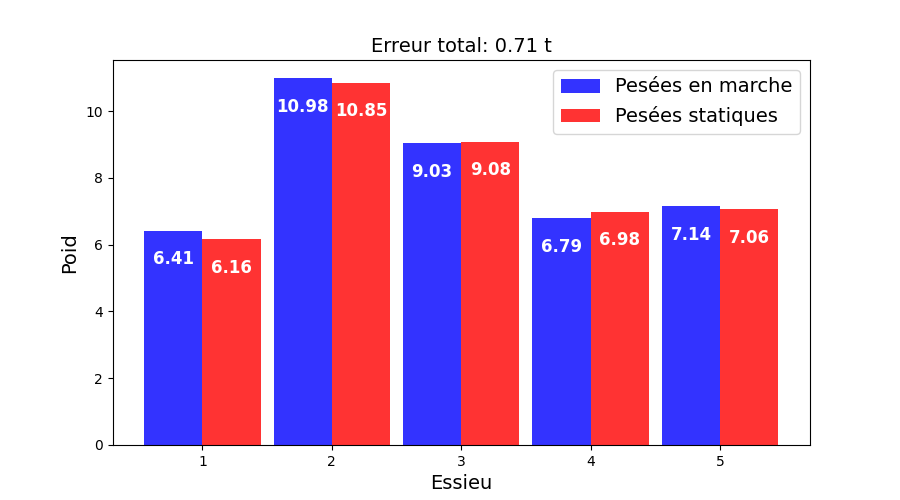

Speed :  23.630778718660313
Peaks :  [265 344 470 496 522]


<IPython.core.display.Javascript object>


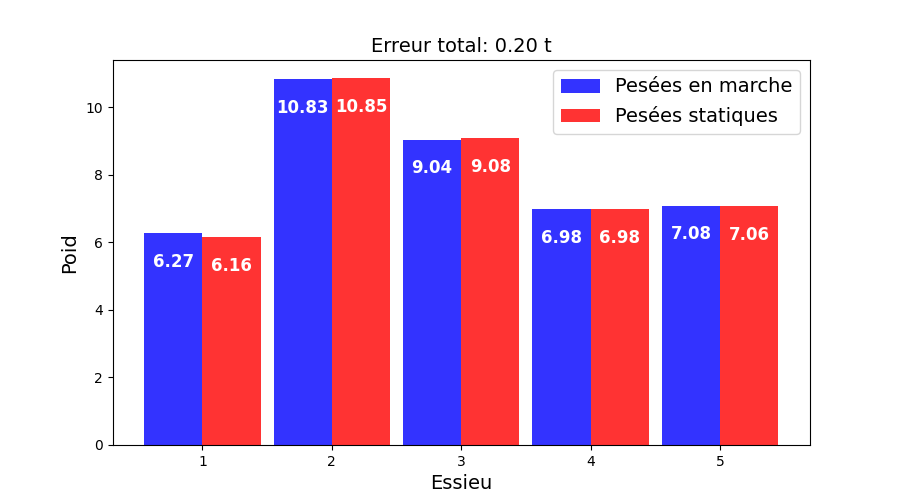

Speed :  21.333341568157582
Peaks :  [265 354 492 521 550]


<IPython.core.display.Javascript object>


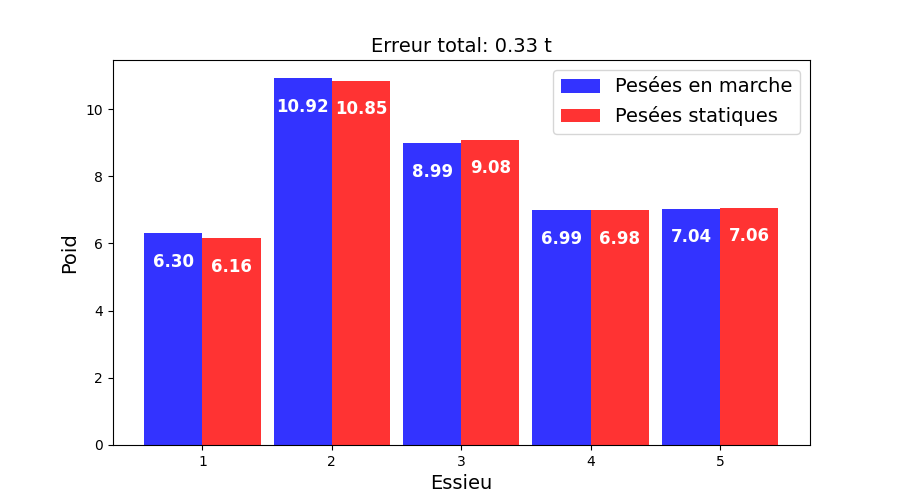

Speed :  23.630769230769232
Peaks :  [317 397 522 549 575]


<IPython.core.display.Javascript object>


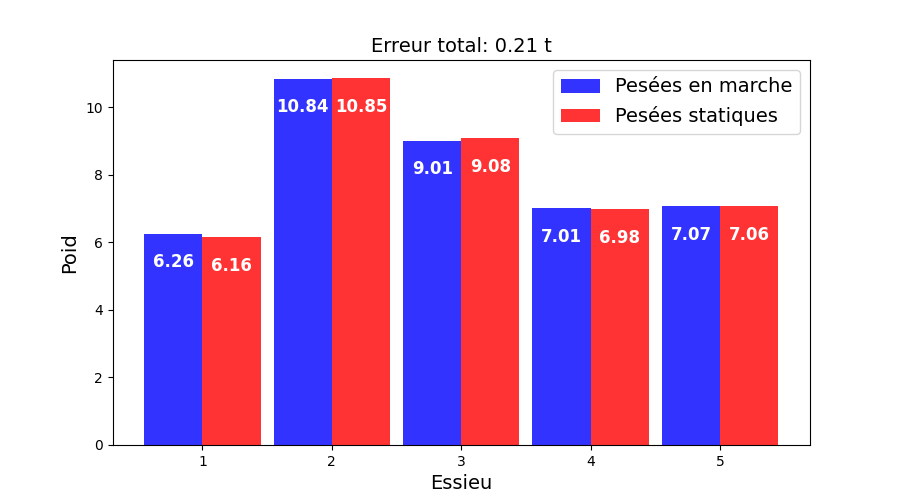

Erreur moyenne  0.36951079875419024
Erreur max :  0.7090346154237501
% erreur moyen :  -0.0025391420185427523


In [24]:
from plot import compare_weights
from Bwifsttar import find_best_peaks,estimation_peaks
import numpy as np

trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

somme=0
max_error = 0
percent_error = 0

for truck in trucks:

    print("Speed : ",truck.speed)
    infl = calibration_decalage(truck)
    peaks = find_best_peaks(truck,2,infl)
    w = estimation_peaks(truck,peaks, infl)
    percent_error += 1-(np.sum(w)/np.sum(truck.weights))
    if(max_error<np.sum(abs(truck.weights -w))):
        
        max_error = np.sum(abs(truck.weights -w))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
    
print("Erreur moyenne " ,somme/len(trucks))
print("Erreur max : ",max_error)
print("% erreur moyen : ",percent_error/len(trucks))

**Camions de traffic**

Speed :  23.630778718660313
Peaks :  [276 351 472 497 522]


<IPython.core.display.Javascript object>


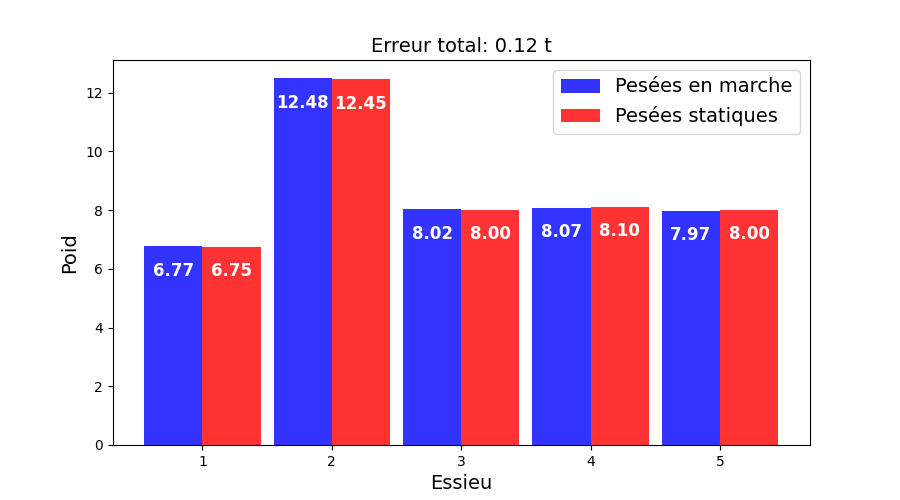

Speed :  24.0
Peaks :  [274 353 477 503 529]


<IPython.core.display.Javascript object>


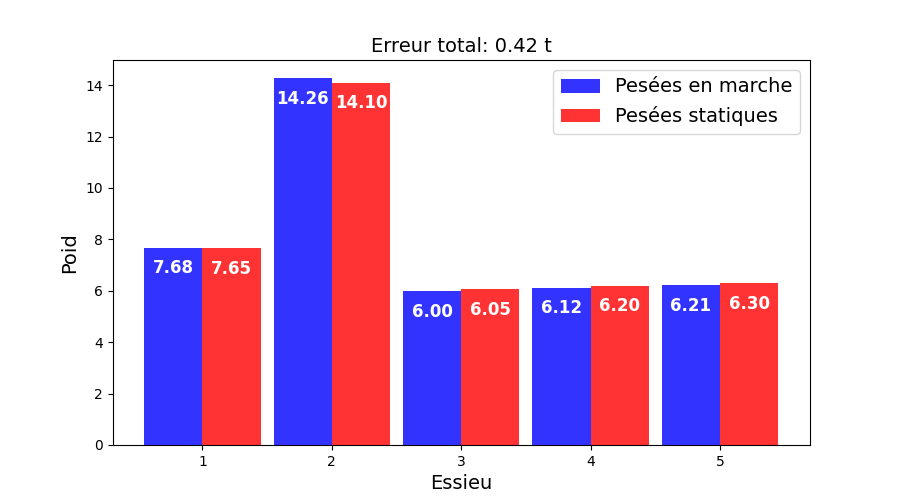

Speed :  23.99998055697778
Peaks :  [276 355 469 492 517]


<IPython.core.display.Javascript object>


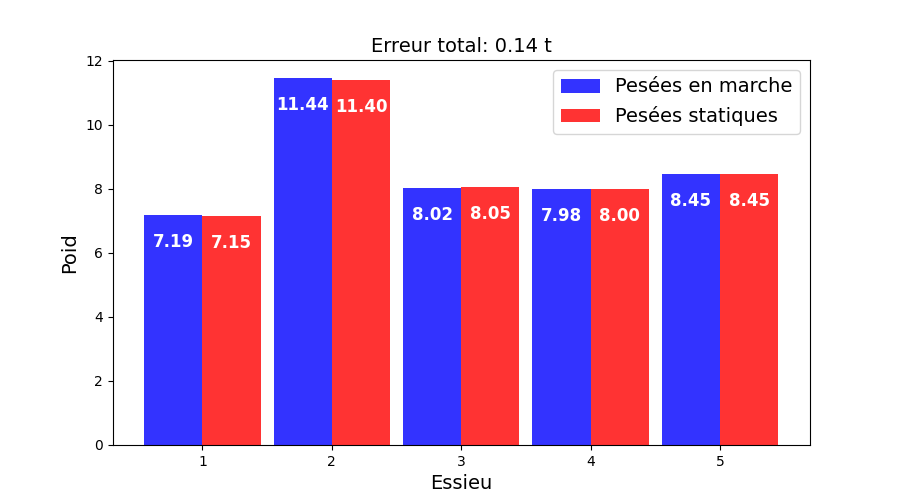

Speed :  24.380962370591252
Peaks :  [276 354 462 487 513]


<IPython.core.display.Javascript object>


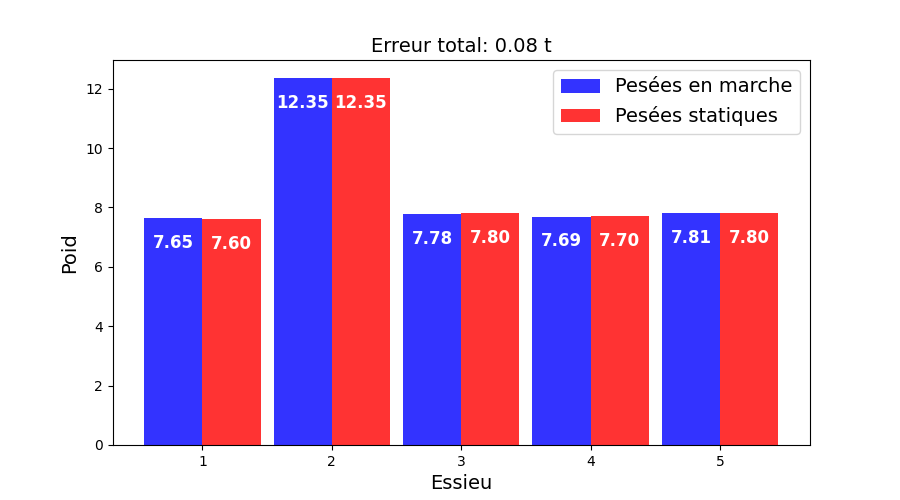

Speed :  23.27274641740299
Peaks :  [274 353 452 478 505]


<IPython.core.display.Javascript object>


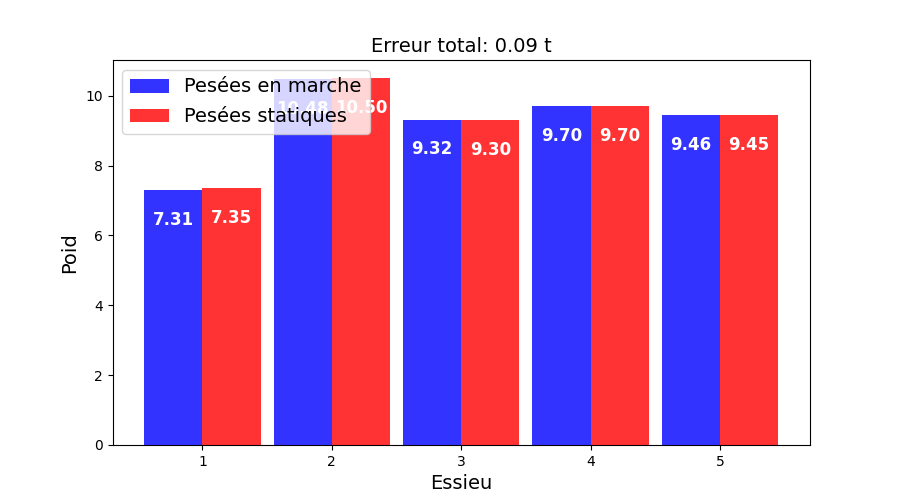

Speed :  25.18025490149026
Peaks :  [277 350 465 489 512]


<IPython.core.display.Javascript object>


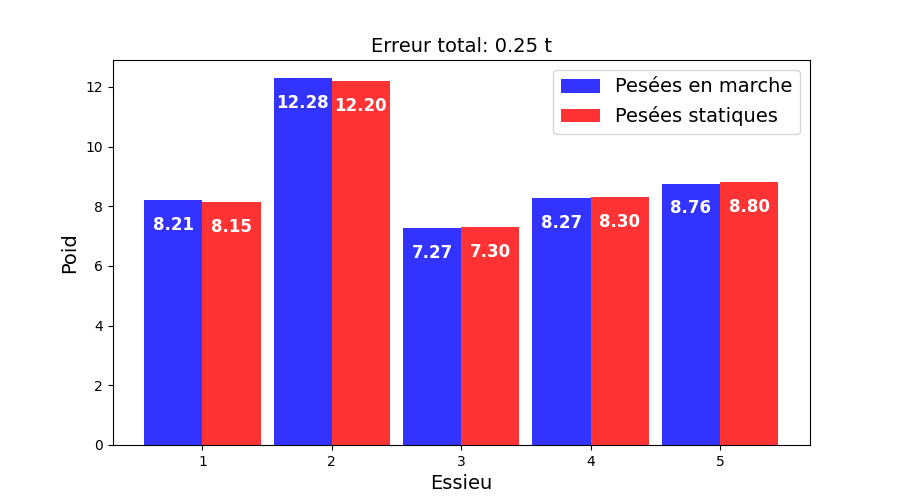

Speed :  22.26084595150235
Peaks :  [272 399 425 518 568 622]


<IPython.core.display.Javascript object>


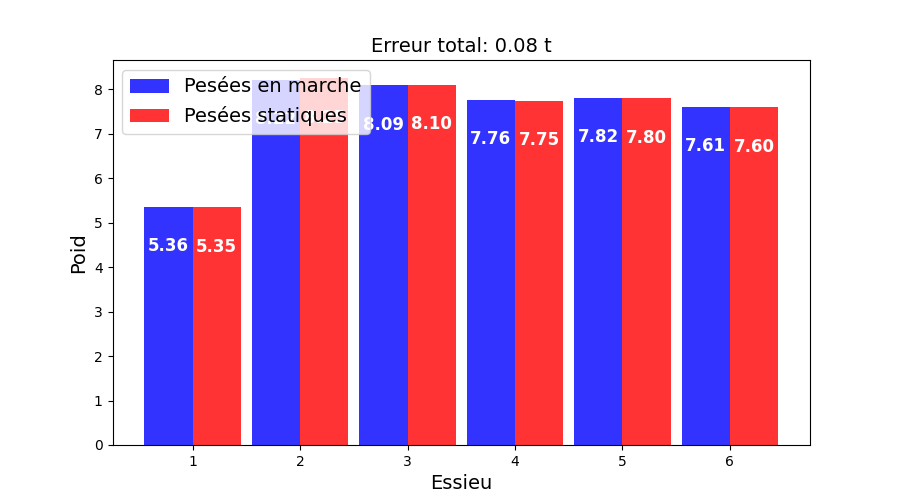

Speed :  23.63081643339881
Peaks :  [277 354 478 503 529]


<IPython.core.display.Javascript object>


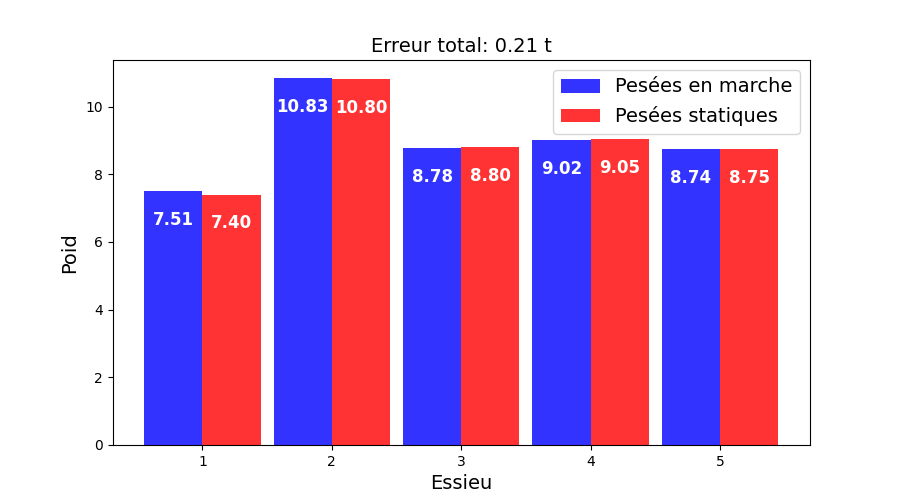

Speed :  22.260903648897617
Peaks :  [275 361 473 501 529]


<IPython.core.display.Javascript object>


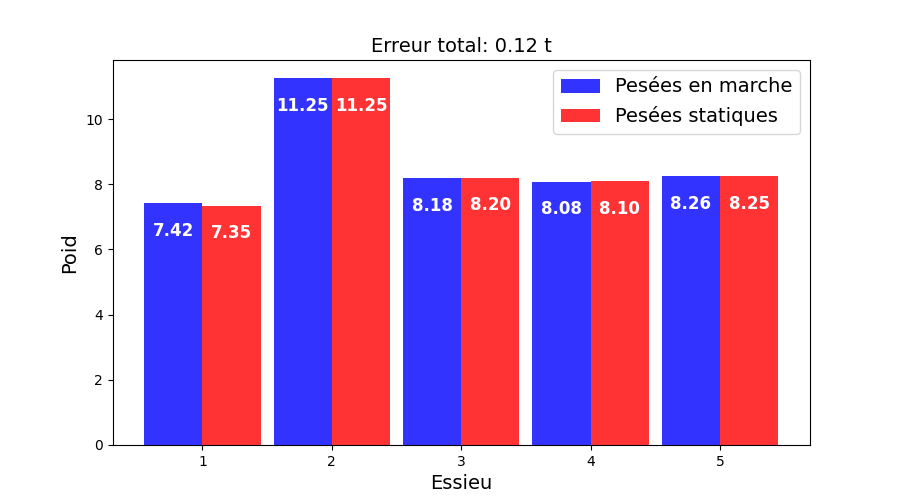

Speed :  23.630750086870428
Peaks :  [271 344 468 493 519]


<IPython.core.display.Javascript object>


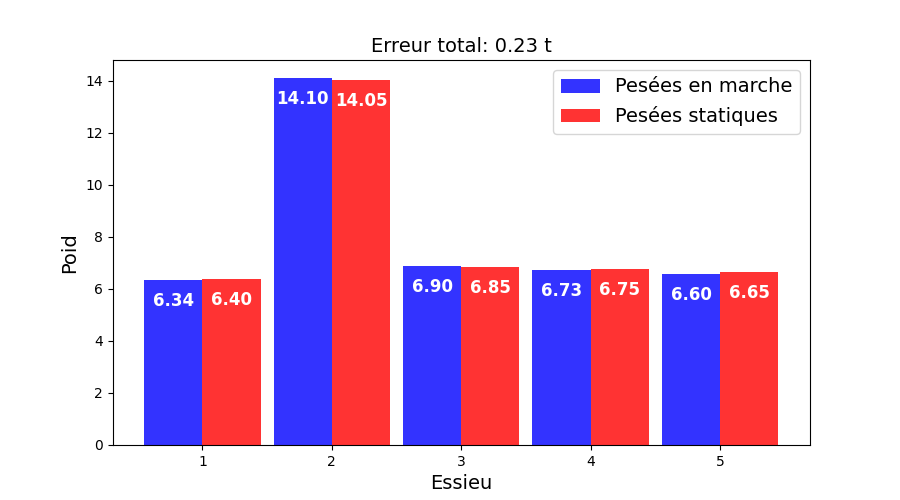

Speed :  23.272717998418727
Peaks :  [277 357 474 502 528]


<IPython.core.display.Javascript object>


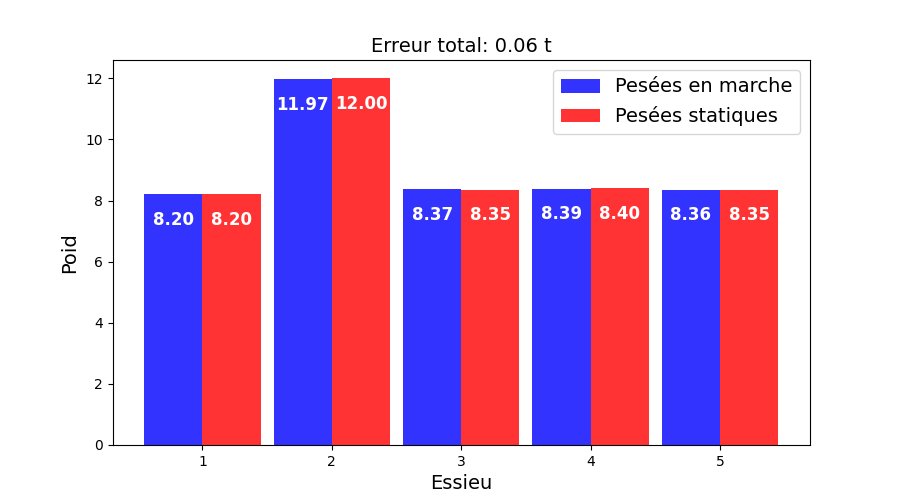

Speed :  24.000047940170667
Peaks :  [276 354 478 503 529]


<IPython.core.display.Javascript object>


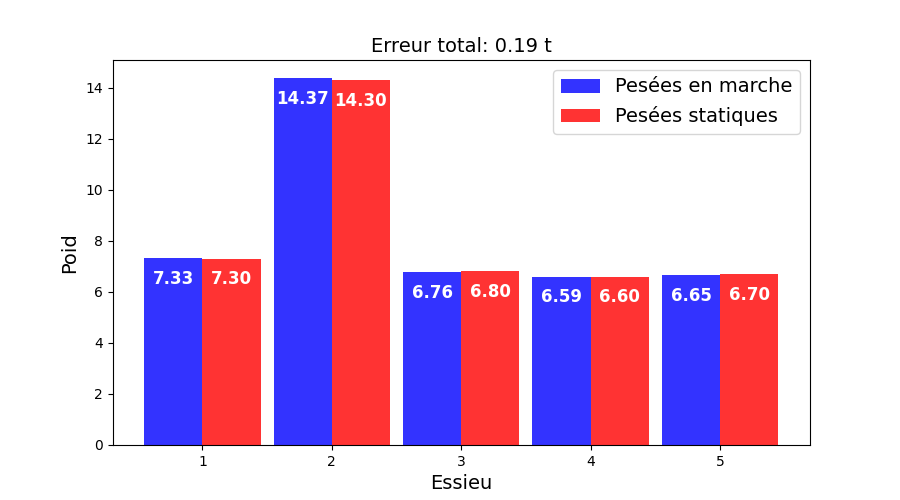

Speed :  24.00002912772182
Peaks :  [274 349 470 495 519]


<IPython.core.display.Javascript object>


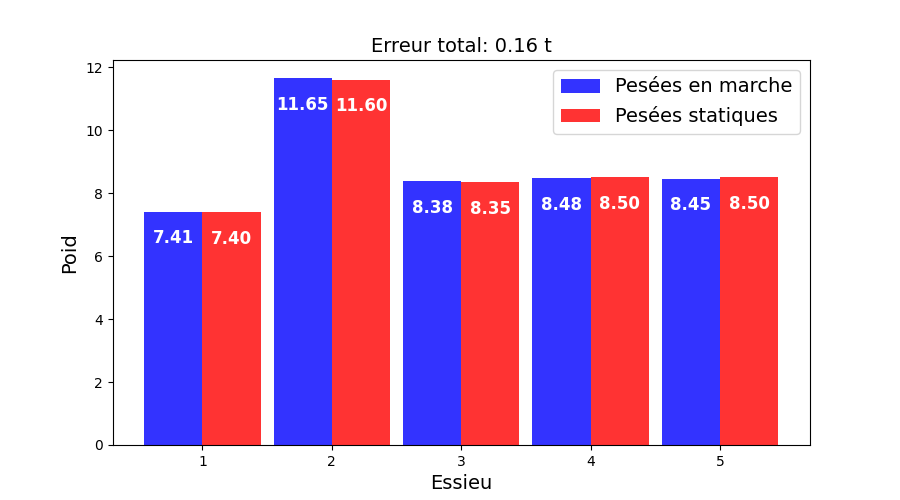

Speed :  24.380892824572964
Peaks :  [275 350 469 493 518]


<IPython.core.display.Javascript object>


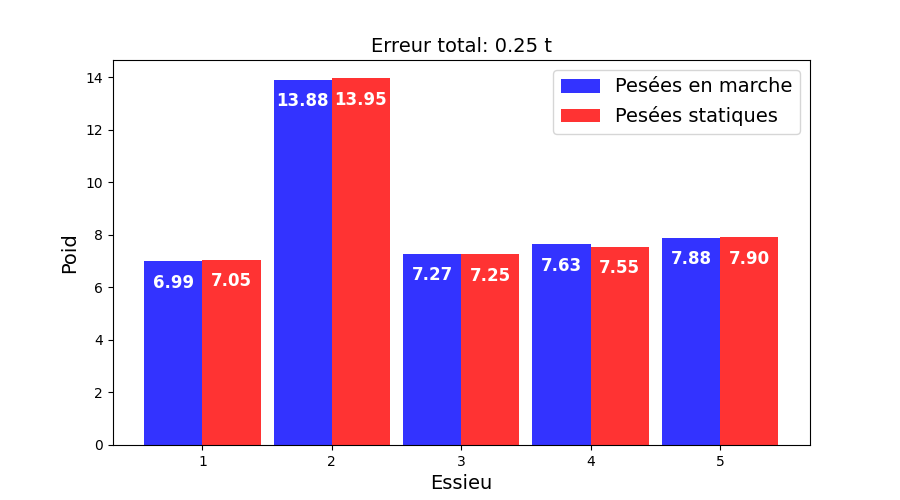

Erreur moyenne  0.17148022260424442
Erreur max :  0.418284593566284
% erreur moyen :  -0.00018374549830491027


In [26]:
from plot import compare_weights

trucks = [truck for truck in calibration_trucks if(len(truck.weights) == len(truck.peaks))]
trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) == len(truck.peaks))]

somme=0
max_error = 0
percent_error = 0

for truck in trucks_t:

    print("Speed : ",truck.speed)
    infl = calibration_decalage(truck)
    peaks = find_best_peaks(truck,2,infl)

    w = estimation_peaks(truck,peaks, infl)
    percent_error += 1-(np.sum(w)/np.sum(truck.weights))
    if(max_error<np.sum(abs(truck.weights -w))):
        
        max_error = np.sum(abs(truck.weights -w))
    somme = np.sum(abs(truck.weights -w))+somme
    compare_weights(w, truck.weights)
    
print("Erreur moyenne " ,somme/len(trucks_t))
print("Erreur max : ",max_error)
print("% erreur moyen : ",percent_error/len(trucks_t))

## IV/ Séparation de deux pics superposés


In [27]:
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
trucks = [truck for truck in calibration_trucks if(len(truck.weights) != len(truck.peaks))]
trucks_t = [truck for truck in traffic_trucks if(len(truck.weights) != len(truck.peaks))]


### IV.1 Isolement des camions concernés

<IPython.core.display.Javascript object>


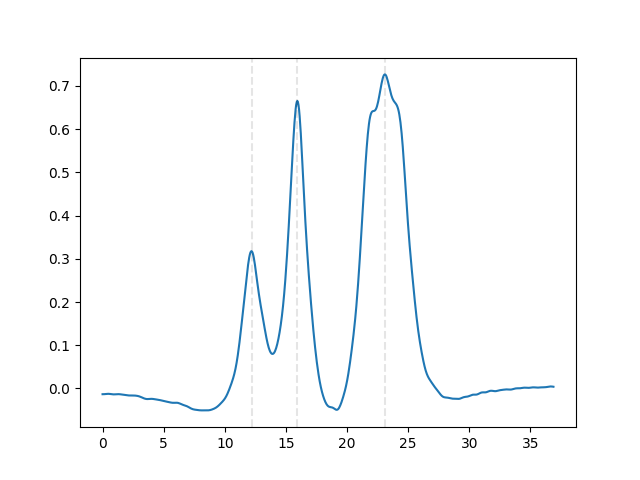

Peaks : [260 340 493]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


<IPython.core.display.Javascript object>


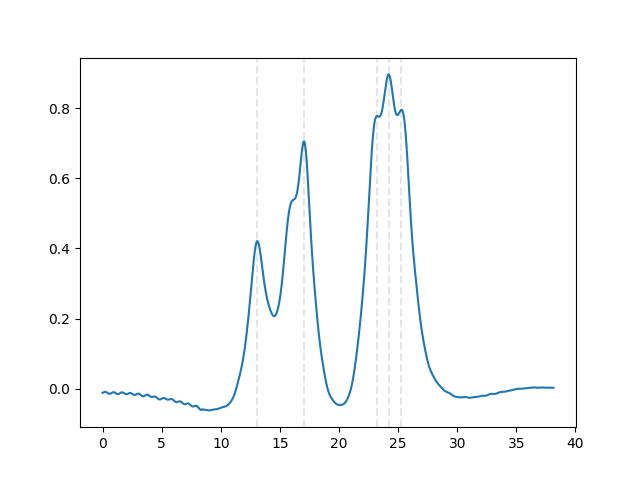

Peaks : [275 358 488 508 531]
Weights :  [6.2  5.05 7.95 7.65 7.4  7.65]


In [28]:

import matplotlib.pyplot as plt
for truck in trucks:
    meters = truck.time*truck.speed
    plt.figure()
    plt.plot(meters,truck.signals)
    print("Peaks :" ,truck.peaks)
    print("Weights : ",truck.weights)
    for p in truck.peaks:
        plt.axvline(meters[p], linestyle='--', color='k', alpha=0.1)
for truck in trucks_t:
    meters = truck.time*truck.speed
    plt.figure()
    plt.plot(meters,truck.signals)
    for p in truck.peaks:
        plt.axvline(meters[p], linestyle='--', color='k', alpha=0.1)
    print("Peaks :" ,truck.peaks)
    print("Weights : ",truck.weights)
plt.show()

### IV.2 Reconstitution des peaks sur les deux camions anormaux

Décalage trouvé


<IPython.core.display.Javascript object>


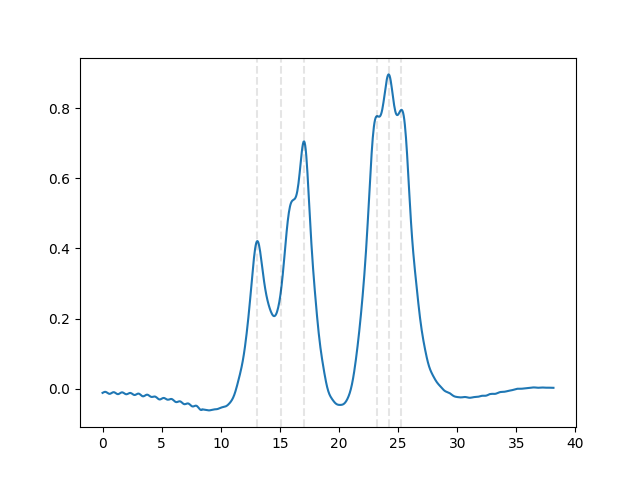

Peaks : [275 358 488 508 531]
Weights :  [6.2  5.05 7.95 7.65 7.4  7.65]
[6.20155534 5.1994036  8.11613322 7.57917451 7.36966865 7.69286702]


<IPython.core.display.Javascript object>


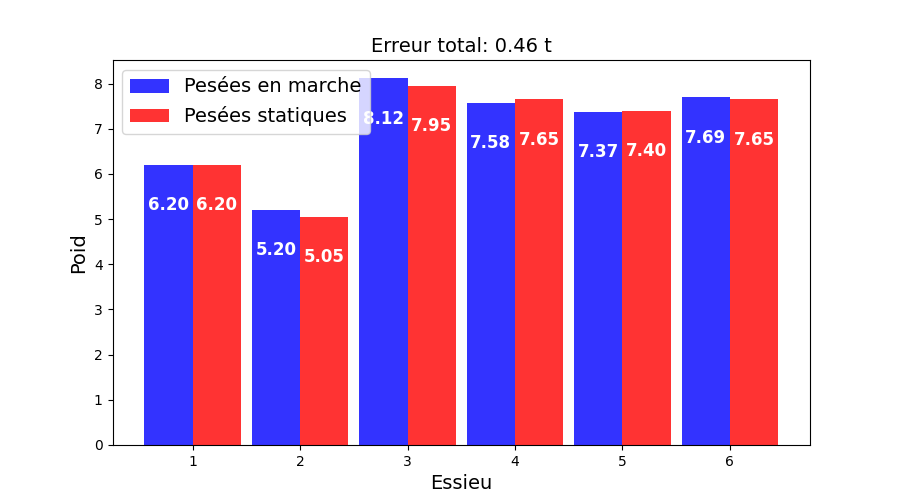

In [29]:
import itertools
import nevergrad as ng
from Bwifsttar import prepare_least_squares_decalage,get_std,prepare_regularization,reconstruction_peaks,estimation_peaks


def calibration_decalage(truck,peaks, l2_reg=None, tv_reg=None):# pour le moment aucune régularization
    
    from scipy.optimize import minimize

    As, bs = prepare_least_squares_decalage(truck,701,peaks)#retourne T et y
    
    for a in As:
        a = a.astype(float)
    for b in bs:
        b = b.astype(float)
    ws = np.array([])
    ws=np.append(ws,1/get_std(truck))
    ws = ws/(np.sum(ws)) #on centre autour de 1   
    
    As, bs = prepare_regularization(As, bs, l2_reg, tv_reg)#Aucune régularisation pour le moment
      
    infl,_, _, _ = np.linalg.lstsq(As,bs, rcond=None)  


    As, bs = prepare_least_squares_decalage(truck,701,peaks)#retourne T et y

    
    #def func_finale_to_min(h_alpha):
    def func_finale_to_min(h,As,Bs,ws):
        


        return ws*np.linalg.norm(As@h-bs)**2



    from scipy.optimize import minimize

    influence_alpha = minimize(func_finale_to_min,infl,method='SLSQP',args=(As,bs,ws),tol=0.001)#utiliser CG pour plus rapidité
    #,constraints=cons
    #res = minimize(func_finale_to_min,params_0)#utiliser CG pour plus rapidité
    resultat = influence_alpha.x
    
    

    
    return influence_alpha.x

def eval_LI(influence_estimee,truck,peaks):
    
    if(len(truck.weights) == len(peaks)):
       
        reconstructed, rescaled = reconstruction_peaks(truck, influence_estimee,peaks)
        meters = truck.speed * truck.time
        diff = truck.signals.T - reconstructed
        de = np.linalg.norm(truck.signals.T - reconstructed)
        #print("Distance euclidienne :" ,de)

       
    else:
        print("Truck non calculable")
    return de

def find_best_position_signal(truck,pos_dec,peaks0,values,influence):#décaler essieu par essieu
    var= 10000
    peaks = peaks0
    for i in values:
        peaks[pos_dec] = i
        res = eval_LI(influence,truck,peaks)
        if(res<var):
            decalage = i
            var = res
            #print(i)
            #print(var)
    print("Décalage trouvé")
    return decalage

truck = trucks_t[0]
signal = truck.signals
nbre_axles = len(truck.weights)
peaks = truck.peaks
idx_peaks = [0,2,3,4,5]
new_peaks = np.zeros(nbre_axles)
for j,i in enumerate(idx_peaks):
    new_peaks[i]=peaks[j]
new_peaks[1] = (new_peaks[2]+new_peaks[0])/2
values = [i for i in range(int(new_peaks[0]),int(new_peaks[2]))]

infl = calibration_decalage(truck,new_peaks,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95})
decalage = find_best_position_signal(truck,1,new_peaks,values,infl) 

peaks_finaux = new_peaks
peaks_finaux[1]=decalage
peaks_finaux

 
meters = truck.time*truck.speed
plt.figure()
plt.plot(meters,truck.signals)
print("Peaks :" ,truck.peaks)
print("Weights : ",truck.weights)
for p in peaks_finaux:
    plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)
    
from plot import compare_weights

w = estimation_peaks(truck,peaks_finaux, infl)
print(w)
compare_weights(w, truck.weights)

In [30]:
import itertools
import nevergrad as ng

def calibration_decalage(truck,peaks, l2_reg=None, tv_reg=None):# pour le moment aucune régularization
    
    from scipy.optimize import minimize

    As, bs = prepare_least_squares_decalage(truck,701,peaks)#retourne T et y
    
    for a in As:
        a = a.astype(float)
    for b in bs:
        b = b.astype(float)
    ws = np.array([])
    ws=np.append(ws,1/get_std(truck))
    ws = ws/(np.sum(ws)) #on centre autour de 1   
    
    As, bs = prepare_regularization(As, bs, l2_reg, tv_reg)#Aucune régularisation pour le moment
      
    infl,_, _, _ = np.linalg.lstsq(As,bs, rcond=None)  


    As, bs = prepare_least_squares_decalage(truck,701,peaks)#retourne T et y

    
    #def func_finale_to_min(h_alpha):
    def func_finale_to_min(h,As,Bs,ws):
        


        return ws*np.linalg.norm(As@h-bs)**2



    from scipy.optimize import minimize

    influence_alpha = minimize(func_finale_to_min,infl,method='SLSQP',args=(As,bs,ws),tol=0.001)#utiliser CG pour plus rapidité
    #,constraints=cons
    #res = minimize(func_finale_to_min,params_0)#utiliser CG pour plus rapidité
    resultat = influence_alpha.x
    
    

    
    return influence_alpha.x

def eval_LI(influence_estimee,truck,peaks):
    
    if(len(truck.weights) == len(peaks)):
       
        reconstructed, rescaled = reconstruction_peaks(truck, influence_estimee,peaks)
        meters = truck.speed * truck.time
        diff = truck.signals.T - reconstructed
        de = np.linalg.norm(truck.signals.T - reconstructed)
        #print("Distance euclidienne :" ,de)

       
    else:
        print("Truck non calculable")
    return de

def find_best_position_signal2(truck,list_pos_dec,peaks0,list_values,influence):#décaler essieu par essieu
    var= 10000
    peaks = peaks0
    for i in list_values[0]:
        peaks[list_pos_dec[0]] = i
        for j in list_values[1]:
            peaks[list_pos_dec[1]] = j

            
            res = eval_LI(influence,truck,peaks)
            if(res<var):
                decalage = [i,j]
                var = res
                #print(i)
                #print(var)
    print("Décalage trouvé")
    return decalage

truck = trucks[0]
signal = truck.signals
nbre_axles = len(truck.weights)
peaks = truck.peaks
idx_peaks = [0,1,3]
new_peaks = np.zeros(nbre_axles)
for j,i in enumerate(idx_peaks):
    new_peaks[i]=peaks[j]
new_peaks[2] = (new_peaks[3]+new_peaks[1])/2
new_peaks[4] = new_peaks[3]+10
values2 = [i for i in range(int(new_peaks[1]),int(new_peaks[3]))]
values4 = [i for i in range(int(new_peaks[4]),int(new_peaks[3]+100))]
new_peaks
infl = calibration_decalage(truck,new_peaks,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 
decalage = find_best_position_signal2(truck,[2,4],new_peaks,[values2,values4],infl) 

Décalage trouvé


Peaks : [260. 340. 416. 493. 503.]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[ 5.24729619 10.0851535   9.37095913  6.8146071   8.02487522]


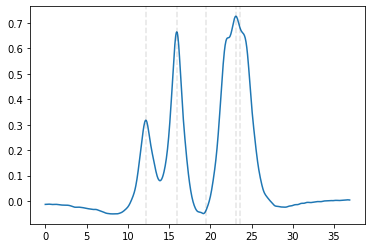

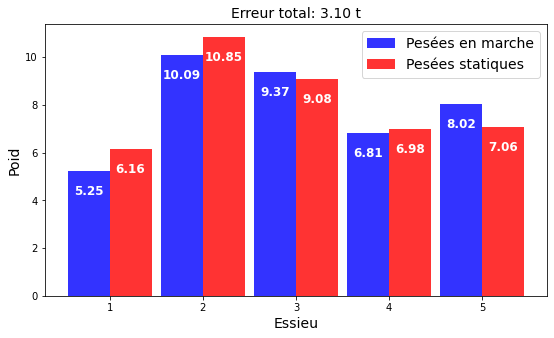

In [22]:
peaks_finaux = new_peaks
peaks_finaux[2]=decalage[0]
peaks_finaux[4]=decalage[1]

meters = truck.time*truck.speed
plt.figure()
plt.plot(meters,truck.signals)
print("Peaks :" ,peaks_finaux)
print("Weights : ",truck.weights)
for p in peaks_finaux:
    plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

from plot import compare_weights

w = estimation_peaks(truck,peaks_finaux, infl)
print(w)
compare_weights(w, truck.weights)

## V/ Recherche automatique de la position de la superpostion (avec largeur des pics)

Pas de superposition
Pas de superposition
[20.7831508  54.23950954  2.85754548 79.99743999  6.35884939]

idx :  3
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition
Pas de superposition


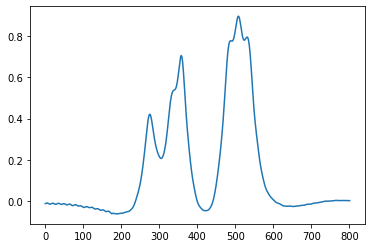

In [25]:
import matplotlib.pyplot as plt
from scipy.signal import peak_widths
calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]

def get_position_superposition(truck):
    """Retourne l'intervalle dans lequel se trouve le pic"""
    signal = truck.signals
    if(len(truck.weights) == len(truck.peaks)):
        print("Pas de superposition")
        return 0
    else:
        plt.figure()
        plt.plot(truck.signals)
        nbre_peaks_missed = abs(len(truck.weights)-len(truck.peaks))         
        peaks_w = peak_widths(signal,truck.peaks)[0]
        print(peaks_w)
        for i,j in enumerate(peaks_w):
            if j==max(peaks_w):
                peak_sup =i
        print("\nidx : ",peak_sup)
    
for truck in traffic_trucks:
    get_position_superposition(truck)

**Le critère de la largeur des pics ne suffit pas à déterminer la position de la superposition**

## VI/ Décalage sur tous les pics (sans superposition ou surestimation)


In [1]:
def find_best_position_signal(truck,pos_dec,peaks0,values):#décaler essieu par essieu
    """
        Données : 
            - truck : namedTuple Truck
            - pos_dec : position où doit être fait le décalage dans la liste peaks
            - peaks0 : Peaks initiaux du camion
            - values : valeurs à tester
        Sorties :
            - decalage : valeur à mettre à pos_dec pour avoir le meilleur résultat
    """
    import numpy as np
    from Bwifsttar import calibration_decalage,eval_LI_peaks
    
    var= 10000
    peaks = peaks0
    for i in values:

        peaks[pos_dec] = i
        infl = calibration_decalage(truck,peaks,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 
        
        
        res = eval_LI_peaks(infl,truck,peaks)
        print(res)
        if(res<var):
            decalage = i
            var = res
            #print(i)
            #print(var)
    print("Décalage trouvé")
    return decalage


In [2]:
def get_position_decalage_(truck):
    """
        Données :
            - truck : namedTuple Truck
        Sorties :
            - peaks : Nouveaux peaks correspondants aux meilleurs résultats
        
    
    """
    import numpy as np
    from Bwifsttar import find_best_position_signal
    
    signal = truck.signals
    peaks = truck.peaks
    weights= truck.weights
    print("PEAKS : ",peaks)
    for i,peak in enumerate(peaks):
        
        
        if i==0:
            values = [k for k in range(int(peaks[i])+50)]
        else:
            values = [k for k in range(int(peaks[i])-50,int(peaks[i])+50)]

            
        print("position décalage",i)
        print("peaks0 : ",peak)
        print("values : ",values)
        
        decalage_found = find_best_position_signal(truck,i,peaks,values) 
        
        print("decalage found : ",decalage_found)
        
        peaks[i] = decalage_found

    return peaks

**Essai sur les camions de calibration**

In [8]:
from Bwifsttar import load_senlis_modified
calibration_trucks,traffic_trucks = load_senlis_modified(6)
for truck in calibration_trucks[0:1]:
    dec = get_position_decalage_(truck)
    meters = truck.time*truck.speed
    plt.figure()
    plt.plot(meters,truck.signals)
    print("Peaks :" ,dec)
    print("Weights : ",truck.weights)
    for p in dec:
        plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

    from plot import compare_weights
    infl = calibration_decalage(truck,dec,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 

    w = estimation_peaks(truck,dec, infl)
    print(w)
    compare_weights(w, truck.weights)


PEAKS :  [266 367 527 559 591]
position décalage 0
peaks0 :  266
values :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,

TypeError: calibration_decalage() got multiple values for argument 'l2_reg'

**Essai sur les camions de traffic**

PEAKS :  [276 351 472 497 522]
position décalage 0
peaks0 :  276
values :  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280]
Décalage trouvé
decalage found :  250
position décalage 1
peaks0 :  351
values :  [301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 3

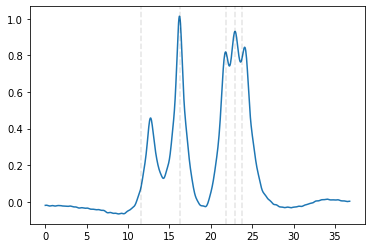

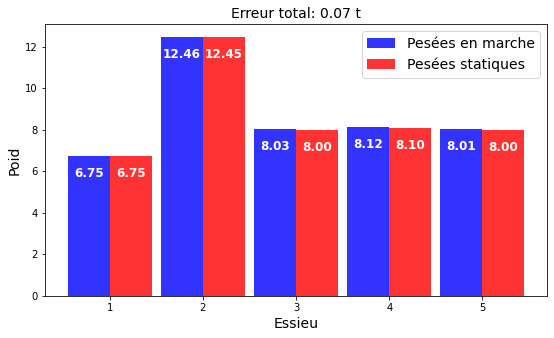

In [14]:
import matplotlib.pyplot as plt
from plot import compare_weights

for truck in traffic_trucks[0:1]:
    try:
        dec = get_position_decalage_(truck)
        meters = truck.time*truck.speed
        plt.figure()
        plt.plot(meters,truck.signals)
        print("Peaks :" ,dec)
        print("Weights : ",truck.weights)
        for p in dec:
            plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

        infl = calibration_decalage(truck,dec,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 

        w = estimation_peaks(truck,dec, infl)
        print(w)
        compare_weights(w, truck.weights) 
        plt.show()
    except:
        continue


PEAKS :  [274 353 477 503 529]
position décalage 0
peaks0 :  274
values :  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278]
Décalage trouvé
decalage found :  278
position décalage 1
peaks0 :  353
values :  [303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 3

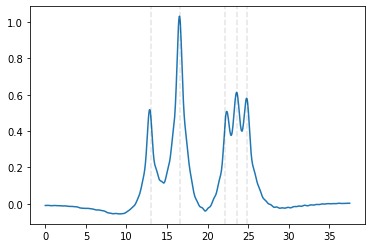

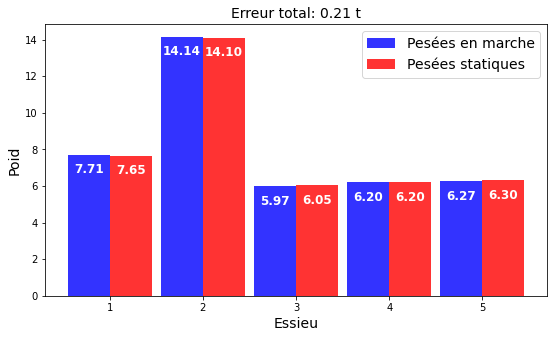

PEAKS :  [275 358 488 508 531]
position décalage 0
peaks0 :  275
values :  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278]
PEAKS :  [276 355 469 492 517]
position décalage 0
peaks0 :  276
values :  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102

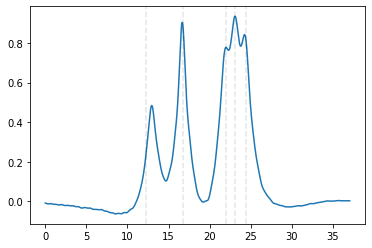

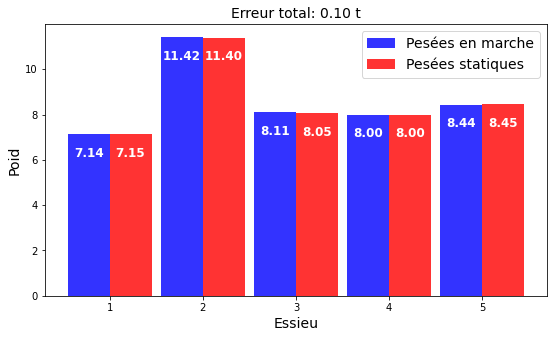

PEAKS :  [276 354 462 487 513]
position décalage 0
peaks0 :  276
values :  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280]
Décalage trouvé
decalage found :  276
position décalage 1
peaks0 :  354
values :  [304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 3

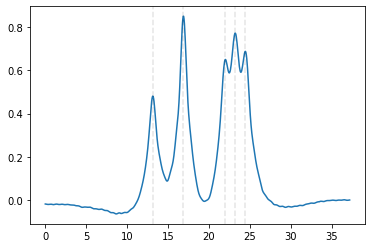

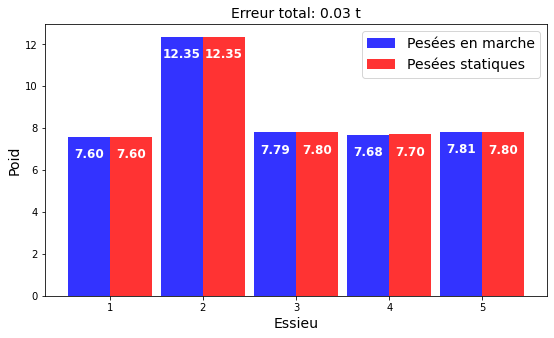

In [13]:
for truck in traffic_trucks[1:5]:
    try:
        dec = get_position_decalage_(truck)
        meters = truck.time*truck.speed
        plt.figure()
        plt.plot(meters,truck.signals)
        print("Peaks :" ,dec)
        print("Weights : ",truck.weights)
        for p in dec:
            plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

        infl = calibration_decalage(truck,dec,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 

        w = estimation_peaks(truck,dec, infl)
        #print(w)
        compare_weights(w, truck.weights) 
        plt.show()
    except:
        continue


## VII/ Reconstruction sur infl0 (méthode indépendante)

(18,)
(18, 701)
(18, 701)
(18, 701)
PEAKS :  [266 367 527 559 591]
position décalage 0
peaks0 :  266
Décalage trouvé
decalage found :  266
position décalage 1
peaks0 :  367
Décalage trouvé
decalage found :  367
position décalage 2
peaks0 :  527
Décalage trouvé
decalage found :  527
position décalage 3
peaks0 :  559
Décalage trouvé
decalage found :  559
position décalage 4
peaks0 :  591
Décalage trouvé
decalage found :  592
Peaks : [266 367 527 559 592]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


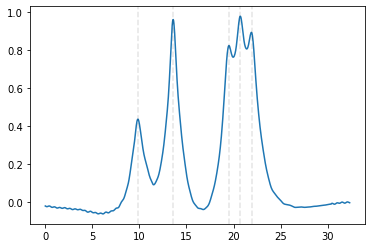

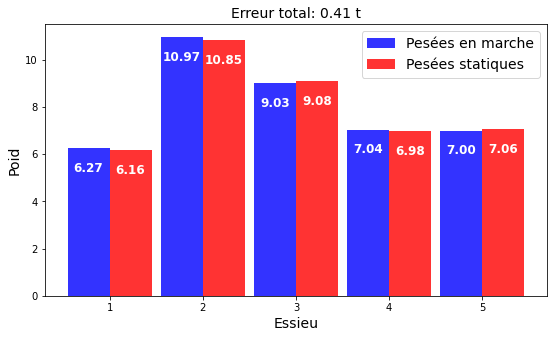

PEAKS :  [263 342 471 494 518]
position décalage 0
peaks0 :  263
Décalage trouvé
decalage found :  260
position décalage 1
peaks0 :  342
Décalage trouvé
decalage found :  343
position décalage 2
peaks0 :  471
Décalage trouvé
decalage found :  463
position décalage 3
peaks0 :  494
Décalage trouvé
decalage found :  499
position décalage 4
peaks0 :  518
Décalage trouvé
decalage found :  524
Peaks : [260 343 463 499 524]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


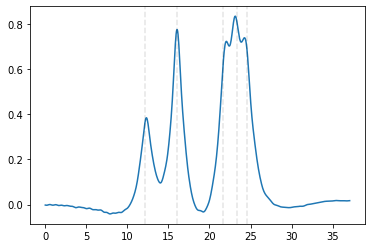

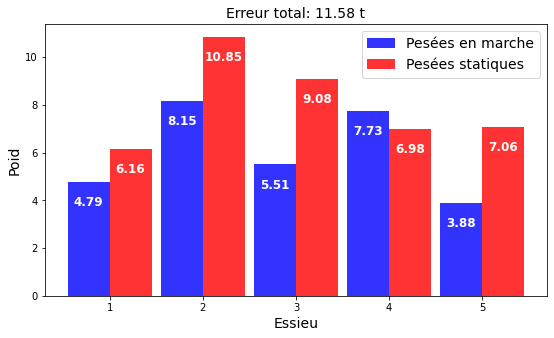

PEAKS :  [266 366 526 558 590]
position décalage 0
peaks0 :  266
Décalage trouvé
decalage found :  266
position décalage 1
peaks0 :  366
Décalage trouvé
decalage found :  366
position décalage 2
peaks0 :  526
Décalage trouvé
decalage found :  526
position décalage 3
peaks0 :  558
Décalage trouvé
decalage found :  558
position décalage 4
peaks0 :  590
Décalage trouvé
decalage found :  591
Peaks : [266 366 526 558 591]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


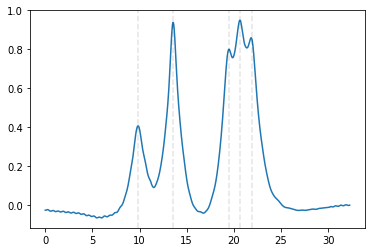

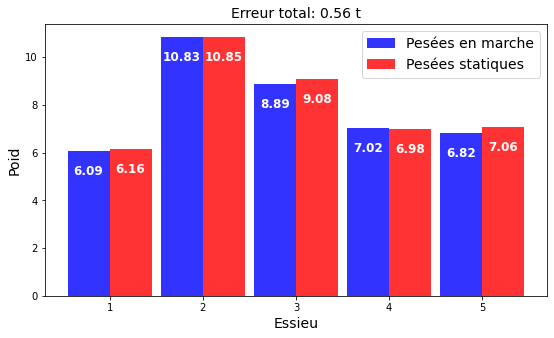

PEAKS :  [263 347 480 508 536]
position décalage 0
peaks0 :  263
Décalage trouvé
decalage found :  262
position décalage 1
peaks0 :  347
Décalage trouvé
decalage found :  348
position décalage 2
peaks0 :  480
Décalage trouvé
decalage found :  477
position décalage 3
peaks0 :  508
Décalage trouvé
decalage found :  511
position décalage 4
peaks0 :  536
Décalage trouvé
decalage found :  539
Peaks : [262 348 477 511 539]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


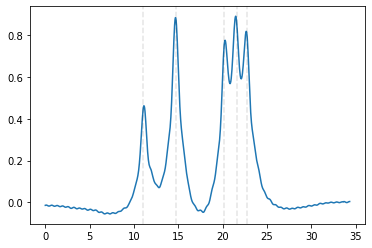

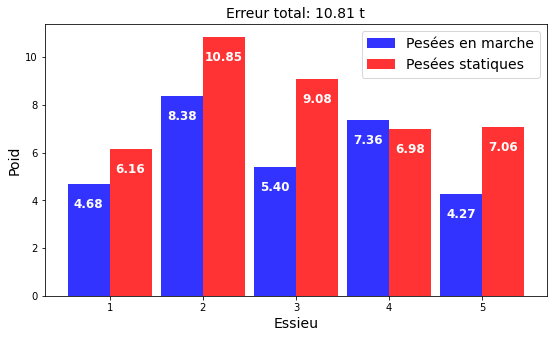

PEAKS :  [261 341 472 492 514]
position décalage 0
peaks0 :  261
Décalage trouvé
decalage found :  258
position décalage 1
peaks0 :  341
Décalage trouvé
decalage found :  341
position décalage 2
peaks0 :  472
Décalage trouvé
decalage found :  459
position décalage 3
peaks0 :  492
Décalage trouvé
decalage found :  499
position décalage 4
peaks0 :  514
Décalage trouvé
decalage found :  523
Peaks : [258 341 459 499 523]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


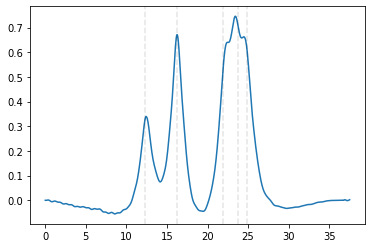

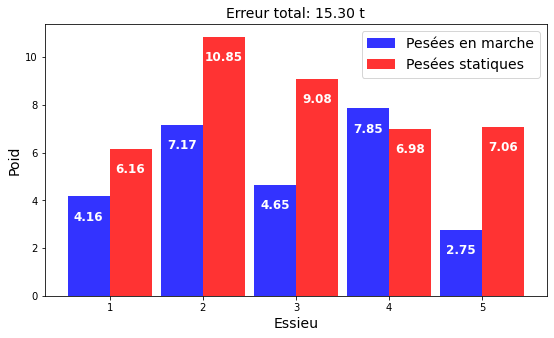

PEAKS :  [266 367 527 560 593]
position décalage 0
peaks0 :  266
Décalage trouvé
decalage found :  266
position décalage 1
peaks0 :  367
Décalage trouvé
decalage found :  367
position décalage 2
peaks0 :  527
Décalage trouvé
decalage found :  527
position décalage 3
peaks0 :  560
Décalage trouvé
decalage found :  560
position décalage 4
peaks0 :  593
Décalage trouvé
decalage found :  593
Peaks : [266 367 527 560 593]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


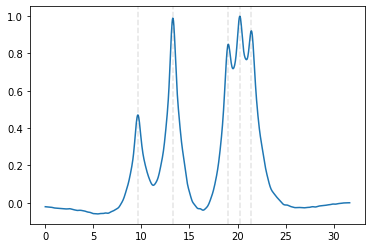

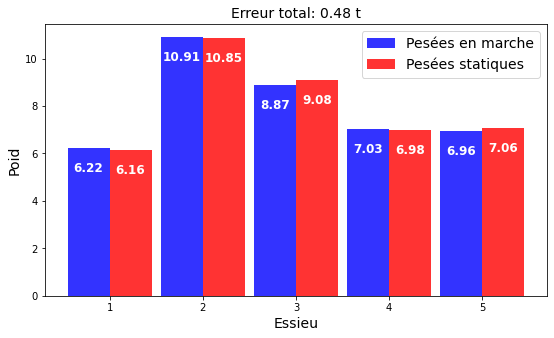

PEAKS :  [262 342 467 494 521]
position décalage 0
peaks0 :  262
Décalage trouvé
decalage found :  260
position décalage 1
peaks0 :  342
Décalage trouvé
decalage found :  343
position décalage 2
peaks0 :  467
Décalage trouvé
decalage found :  463
position décalage 3
peaks0 :  494
Décalage trouvé
decalage found :  498
position décalage 4
peaks0 :  521
Décalage trouvé
decalage found :  525
Peaks : [260 343 463 498 525]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


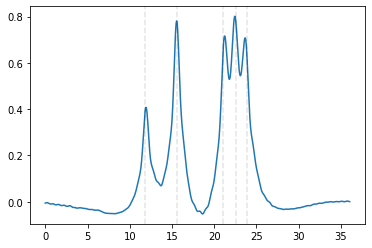

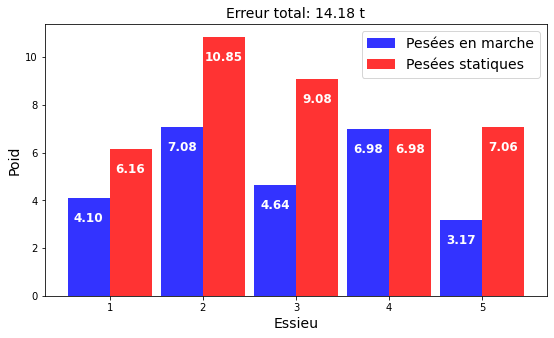

PEAKS :  [266 368 528 561 593]
position décalage 0
peaks0 :  266
Décalage trouvé
decalage found :  266
position décalage 1
peaks0 :  368
Décalage trouvé
decalage found :  368
position décalage 2
peaks0 :  528
Décalage trouvé
decalage found :  528
position décalage 3
peaks0 :  561
Décalage trouvé
decalage found :  561
position décalage 4
peaks0 :  593
Décalage trouvé
decalage found :  595
Peaks : [266 368 528 561 595]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


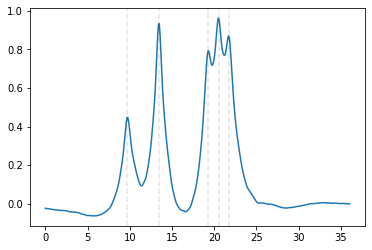

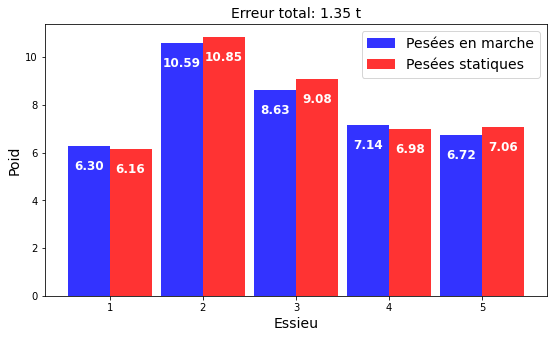

PEAKS :  [265 344 470 496 522]
position décalage 0
peaks0 :  265
Décalage trouvé
decalage found :  264
position décalage 1
peaks0 :  344
Décalage trouvé
decalage found :  344
position décalage 2
peaks0 :  470
Décalage trouvé
decalage found :  467
position décalage 3
peaks0 :  496
Décalage trouvé
decalage found :  500
position décalage 4
peaks0 :  522
Décalage trouvé
decalage found :  525
Peaks : [264 344 467 500 525]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


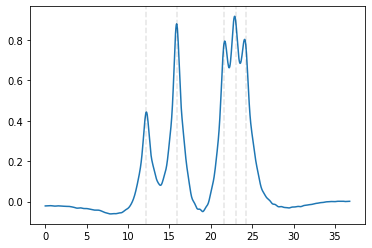

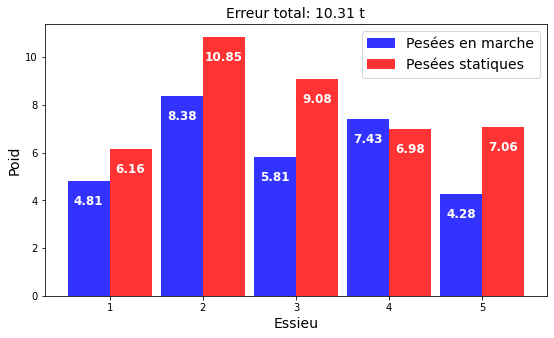

PEAKS :  [265 354 492 521 550]
position décalage 0
peaks0 :  265
Décalage trouvé
decalage found :  264
position décalage 1
peaks0 :  354
Décalage trouvé
decalage found :  354
position décalage 2
peaks0 :  492
Décalage trouvé
decalage found :  491
position décalage 3
peaks0 :  521
Décalage trouvé
decalage found :  524
position décalage 4
peaks0 :  550
Décalage trouvé
decalage found :  552
Peaks : [264 354 491 524 552]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


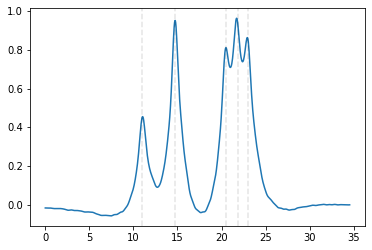

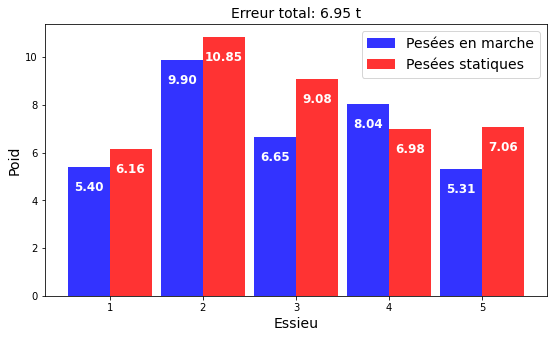

PEAKS :  [317 397 522 549 575]
position décalage 0
peaks0 :  317
Décalage trouvé
decalage found :  316
position décalage 1
peaks0 :  397
Décalage trouvé
decalage found :  397
position décalage 2
peaks0 :  522
Décalage trouvé
decalage found :  518
position décalage 3
peaks0 :  549
Décalage trouvé
decalage found :  553
position décalage 4
peaks0 :  575
Décalage trouvé
decalage found :  580
Peaks : [316 397 518 553 580]
Weights :  [ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


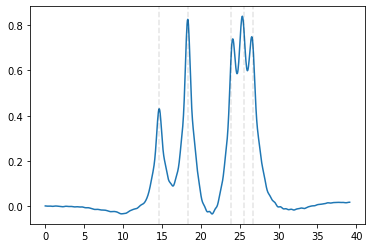

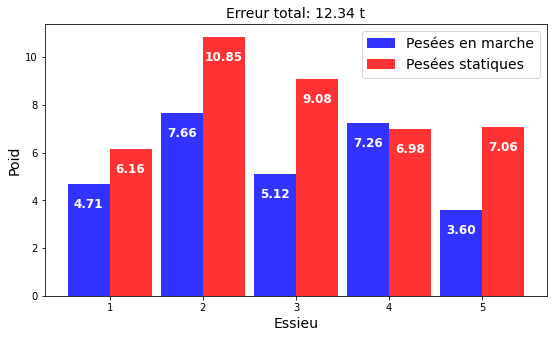

In [16]:

calibration_trucks,traffic_trucks = load_senlis_modified(selected=6) #[3,4,6,7]
from plot import compare_weights
import matplotlib.pyplot as plt

for truck in calibration_trucks:
    if(len(truck.weights)==len(truck.peaks)):
        dec = get_position_decalage_(truck,infl0)
        meters = truck.time*truck.speed
        plt.figure()
        plt.plot(meters,truck.signals)
        print("Peaks :" ,dec)
        print("Weights : ",truck.weights)
        for p in dec:
            plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

        #infl = calibration_decalage(truck,dec,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 

        w = estimation_peaks(truck,dec, infl0)
        #print(w)
        compare_weights(w, truck.weights) 
        plt.show()


**On constate que cette méthode ne marche pas lorsque la vitesse augmente**

## VIII/ Surestimation du nombre d'essieux

In [13]:


def get_position_1_decalage(truck):
    if (len(truck.weights)==len(truck.peaks)):
        signal = truck.signals
        peaks = truck.peaks
        weights= truck.weights

        #print("Peaks : ",peaks)
        #print("Weights : ",weights)
        list_decalages = []
        for i in range(len(weights)+1):# pour i allant de 0 au nombre d'essieux
            new_peaks = np.zeros(len(weights)+1)# les peaks finaux ont la longueur du nombre d'essieux
            idx_values = [a for a in range(len(truck.weights)+1) if a != i]
            print(idx_values)
            for k,j in enumerate(idx_values):
                new_peaks[j] = peaks[k]
                if i!=0: 
                    new_peaks[i] = peaks[i-1]
            list_decalages.append(new_peaks)
        print("Liste décalage : ",list_decalages)

        list_df = []
        lits_evals = []
        for i,decalage in enumerate(list_decalages):
            #print("first infl found")

            if i+1 < len(decalage):
                values = [k for k in range(int(decalage[i]),int(decalage[i+1]))]
            else:
                values = [k for k in range(int(decalage[i]),int(decalage[i]+100))]

            print("position décalage",i)
            print("peaks0 : ",decalage)
            print("values : ",values)
            pt = poids_tot(truck,func1D(truck.speed))

            weights = gen_essieux(40,len(truck.weights)+1)

            decalage_found = find_best_position_signal(weights,truck,i,decalage,values) 
            print("decalage found : ",decalage_found)
            list_df.append(decalage_found)
            #print(decalage_found)
            decalage[i] = decalage_found
            infl = func1D(truck.speed)
            #print("2nd infl found")
            eval_li = eval_LI(weights,infl,truck,decalage)
            lits_evals.append(eval_li)
            #print("eval li ",eval_li)
            #print("\n")
            print("Liste decalages : ",list_decalages)
        for i,j in enumerate(lits_evals):
            if j == min(lits_evals):
                return list_decalages[i]
""" 
from plot import compare_weights
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
for truck in traffic_trucks:
    plt.figure()
    plt.plot(truck.signals)
    plt.show()
    print(truck.peaks)
    dec = get_position_1_decalage(truck)

for truck in calibration_trucks:
    if(len(truck.weights)==len(truck.peaks)):
        dec = get_position_1_decalage(truck)
        meters = truck.time*truck.speed
        plt.figure()
        plt.plot(meters,truck.signals)
        print("\n\n\nPeaks :" ,dec)
        #print("Weights : ",truck.weights)
        for p in dec:
            print("BOUCLE")
            plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)

        #infl = calibration_decalage(truck,dec,l2_reg={'strength': 1e3, 'cutoff': 0.01},tv_reg={'strength': 1e3, 'cutoff': 0.95}) 
        #infl = func1D(truck.speed)
        #w = estimation_peaks(truck,dec, infl)
        #print(w)
        #compare_weights(w, truck.weights) 
        plt.show()"""


(18,)
(18, 701)
(18, 701)
(18, 701)


' \nfrom plot import compare_weights\nimport matplotlib.pyplot as plt\nimport matplotlib.pyplot as plt\nfor truck in traffic_trucks:\n    plt.figure()\n    plt.plot(truck.signals)\n    plt.show()\n    print(truck.peaks)\n    dec = get_position_1_decalage(truck)\n\nfor truck in calibration_trucks:\n    if(len(truck.weights)==len(truck.peaks)):\n        dec = get_position_1_decalage(truck)\n        meters = truck.time*truck.speed\n        plt.figure()\n        plt.plot(meters,truck.signals)\n        print("\n\n\nPeaks :" ,dec)\n        #print("Weights : ",truck.weights)\n        for p in dec:\n            print("BOUCLE")\n            plt.axvline(meters[int(p)], linestyle=\'--\', color=\'k\', alpha=0.1)\n\n        #infl = calibration_decalage(truck,dec,l2_reg={\'strength\': 1e3, \'cutoff\': 0.01},tv_reg={\'strength\': 1e3, \'cutoff\': 0.95}) \n        #infl = func1D(truck.speed)\n        #w = estimation_peaks(truck,dec, infl)\n        #print(w)\n        #compare_weights(w, truck.weights) 

[1, 2, 3, 4, 5]
[0, 2, 3, 4, 5]
[0, 1, 3, 4, 5]
[0, 1, 2, 4, 5]
[0, 1, 2, 3, 5]
[0, 1, 2, 3, 4]
Liste décalage :  [array([  0., 266., 367., 527., 559., 591.]), array([266., 266., 367., 527., 559., 591.]), array([266., 367., 367., 527., 559., 591.]), array([266., 367., 527., 527., 559., 591.]), array([266., 367., 527., 559., 559., 591.]), array([266., 367., 527., 559., 591., 591.])]
position décalage 0
peaks0 :  [  0. 266. 367. 527. 559. 591.]
values :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 13

3.1421520853857206
3.1292397851548697
3.116089453199688
3.102685695937084
3.089015270267986
3.0750673306595955
3.060833621462782
3.0463085752536525
3.0314892933760422
3.01637540045912
3.000968789674596
2.9852732869547984
2.969294279582127
2.953038355358817
2.9365129985373737
2.9197263776252993
2.90268737215024
2.885405396900786
2.867890331632988
2.8501524827779012
2.832203820857079
2.814058580645636
2.795732564412701
2.7772430350087918
2.758608480074314
2.7398486040856382
2.720984364651508
2.702037209695055
2.683027881506572
2.6639756759664484
2.6448983537535047
2.6258122275250324
2.6067320737164463
2.5876710291208163
2.5686405682099127
2.549650607017347
2.5307097368520934
2.511825645002439
2.4930057901958196
2.4742584110774546
2.4555938867682805
2.437026474613968
2.418576733564378
2.400274356981952
2.3821608047342018
2.364292496518418
2.3467434681707737
2.329607612833385
2.3130000697136195
2.2970574349790316
2.28193651751305
2.267811450413397
2.254869089015392
2.24330279505741
2.23330

3.6367684036101298
3.6483972865918215
3.6602858945664702
3.672533471655382
3.6852283457175
3.6984445453781465
3.7122393709662282
3.7266520816447577
3.7417036459276565
3.7573975432362476
3.7737214712365303
3.790649712169202
3.8081459071743016
3.82616596090087
3.8446608308694485
3.8635789936473057
3.88286845144702
3.9024782069768102
3.922359201119865
3.9424647632549616
3.9627506661691934
3.9831749006309245
4.003697291465414
4.024279066360565
4.044882471887419
4.065470498537366
4.086006746172423
4.106455437919553
4.12678156397227
4.1469511470240095
4.166931572749938
4.186691880826655
4.20620286119438
4.225437175362542
4.24436982949261
4.262978863185453
4.281245631369401
4.299154436952602
4.316692153702822
4.333848018459457
4.350613390965456
4.366981492250898
4.3829471059151475
4.398506231832836
4.413655728997711
4.428392951092034
4.442715384033486
4.4566203286204455
4.470104650391434
4.48316462646748
4.495795913965105
4.507993651861537
4.519752695030314
4.531067962591415
4.541934866856651

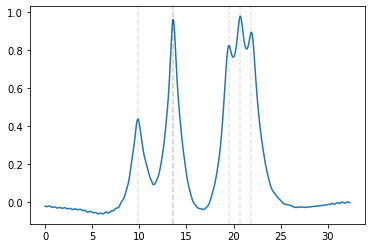

In [18]:
from plot import compare_weights
import matplotlib.pyplot as plt

truck = calibration_trucks[0]
dec = get_position_1_decalage(truck)
meters = truck.time*truck.speed
plt.figure()
plt.plot(meters,truck.signals)
for p in dec:
    print("axline")
    plt.axvline(meters[int(p)], linestyle='--', color='k', alpha=0.1)
w = estimation_peaks(truck,dec, infl)

In [20]:
print(dec)
print(truck.weights)
print(w)

[266. 367. 367. 527. 559. 591.]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[ 8.08113602  7.84754465  7.84754465 11.44443008  9.41401152 11.88909749]


[266 367 527 559 591]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[263 342 471 494 518]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[266 366 526 558 590]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[263 347 480 508 536]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[261 341 472 492 514]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[266 367 527 560 593]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[262 342 467 494 521]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[266 368 528 561 593]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[265 344 470 496 522]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[265 354 492 521 550]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]
[317 397 522 549 575]
[ 6.16068 10.8499   9.08406  6.98472  7.0632 ]


<ipython-input-8-f5a41b765854>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-8-f5a41b765854>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


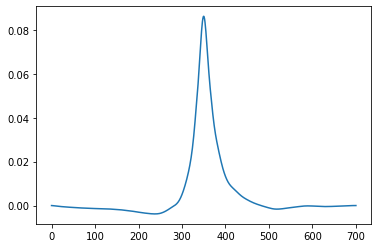

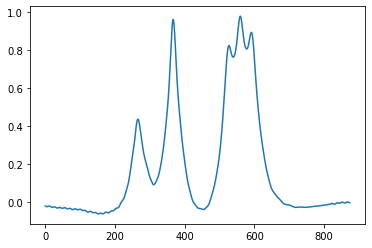

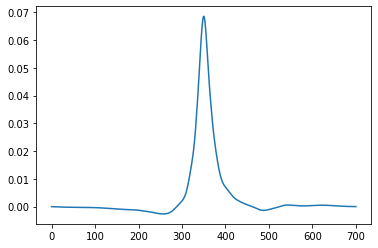

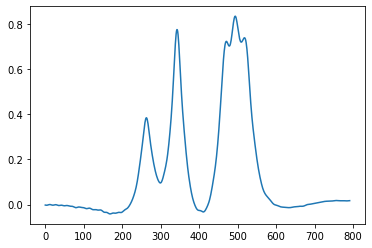

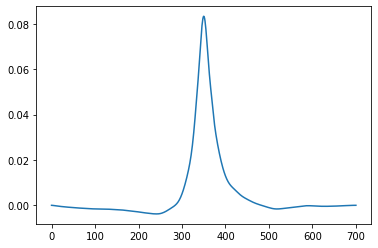

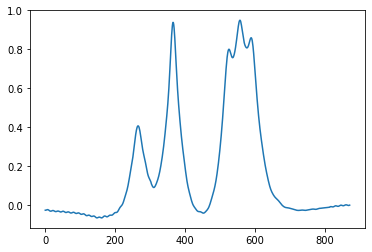

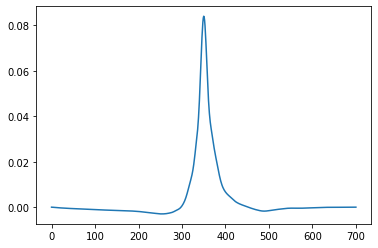

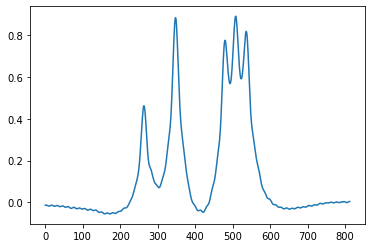

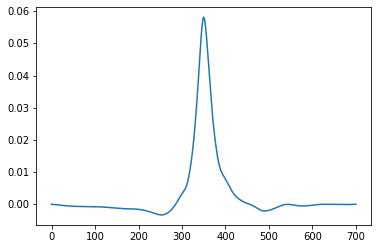

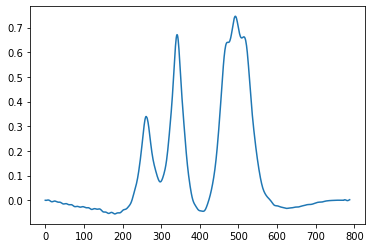

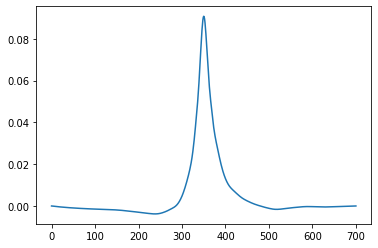

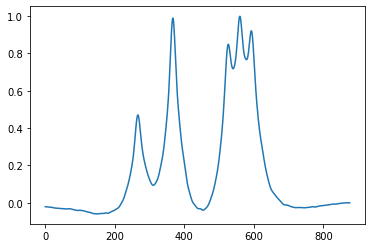

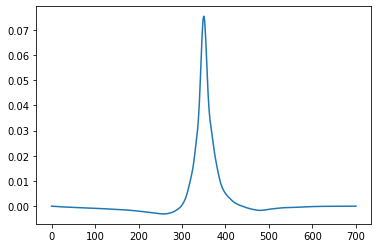

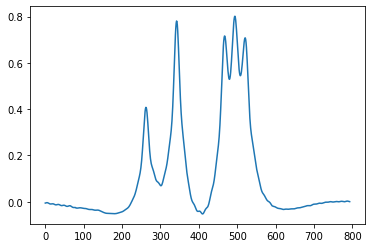

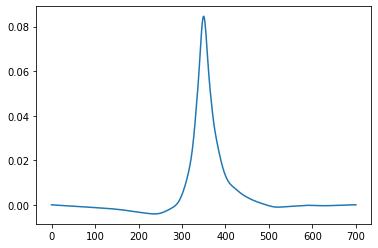

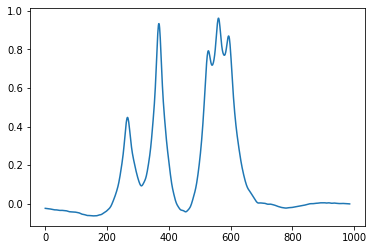

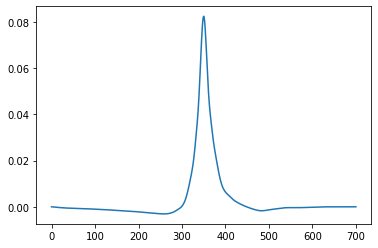

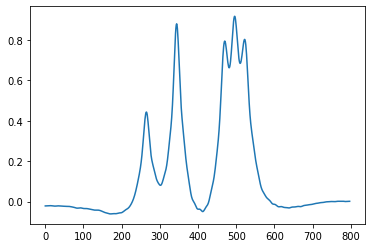

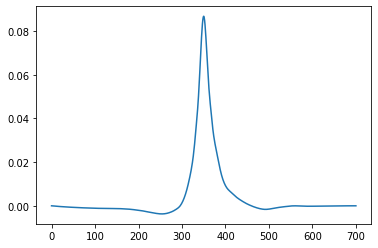

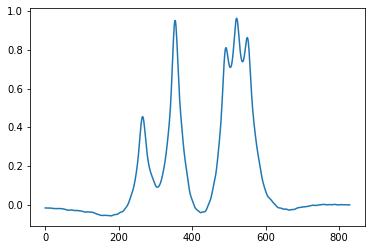

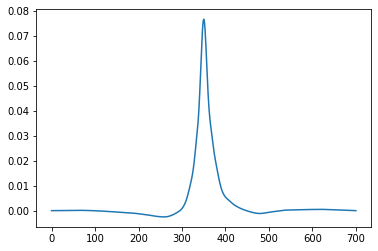

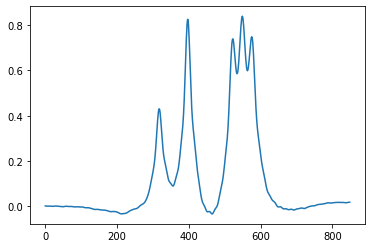

In [8]:
for truck in trucks:
    print(truck.peaks)
    plt.figure()
    plt.plot(func1D(truck.speed))
    plt.figure()
    plt.plot(truck.signals)
    print(truck.weights)